To Do:
* Confusion matrix diagram for best model
* Add explanation for why to use SMOTE, options of over and/or under sampling.
* Add in other models to this notebook

# Library Install

We need to install a previous version of matplotlib, otherwise seaborn heatmaps/confusion matrix will be broken

In [1]:
pip install matplotlib==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Functions to move

In [28]:
def best_model_score(clf, param_grid, X_train, y_train, X_test, y_test, scoring='f1', cv=3, n_jobs=-1):
    '''Conducts Gridsearch to return the best test data accuracy and f1 score for a classifier as well as y_pred'''
    
    # Create GridSearch Object
    grid_clf = GridSearchCV(clf, 
                            param_grid, 
                            scoring='f1', 
                            cv=cv
                           )

    # Fit our GridSearch Object and pass  in the training data
    grid_clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = grid_clf.predict(X_test)
    y_pred_proba = grid_clf.predict_proba(X_test)
    
    # Best F1 Score
    best_f1 = f1_score(y_test, y_pred)
    print('Best Test Data F1 score: {}'.format(round(best_f1, 5)))
    
    # Best Recall Score
    best_recall = recall_score(y_test, y_pred)
    print('Best Test Data Recall score: {}'.format(round(best_f1, 5)))
    
    # Best Parameters
    print('\nOptimal parameters:')
    best_parameters = grid_clf.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print('\t{}: {}'.format(param_name, best_parameters[param_name]))    
    
#     # Classification report
#     print('\n', classification_report(y_test, y_pred))
    
    return best_f1, best_recall, y_pred, y_pred_proba

In [62]:
def combination_for_best_score(df):
    ''' Return the highest score and prints the associated combination of resampling and classifier'''
    index_positions = []
    max_score = df.max().max()
    
    # Find where the max F1 score is (NB could be more than one max value)
    df_bool_max_score = df.isin([max_score])
    # Find index/classifier that contains the max F1 score
    best_classifier_row = df_bool_max_score.any()
    best_classifier_name = list(best_classifier_row[best_classifier_row == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in best_classifier_name:
        rows = list(df_bool_max_score[col][df_bool_max_score[col] == True].index)
        for row in rows:
            index_positions.append((row, col))
    
    print('The highest score was {}'.format(round(max_score, 4)))
    best_classifier = index_positions[0][0]
    best_resampling = index_positions[0][1]
    print('This was achieved by resampling with {} and using the {} classifier'.format(best_resampling, best_classifier))
    
    return max_score

# Library Imports

In [17]:
# Dataframes
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation
    # Train:Test
from sklearn.model_selection import train_test_split
    # Scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# # Model metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# # Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [6]:
random_seed = 1

# Introduction

three major approaches to handle imbalanced data: data sampling, algorithm modifications, and cost-sensitive learning.

# Import Cleaned Data 

In [7]:
df = pd.read_csv('../data/processed/cleaned_dataframe.gz', compression='gzip')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# Train:Test Split

In [8]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=random_seed)

print("No. of samples in each training set:\t{}".format(X_train.shape[0]))
print("No. of samples in each test set:\t{}".format(X_test.shape[0]))

No. of samples in each training set:	199364
No. of samples in each test set:	85443


* We choose to stratify as we want to keep the distribution of classes the same in the training set as the test set. 
* Additionally we must ensure there are at least some fraudulent transactions in the test dataset.

# Scaling

* Scaling the data will improve the predictive performance of some machine learning models.  
    * Without scaling, gradient-based estimating models (such as linear or logistic regression) will take longer to converge or may not be able to converge at all.

In [9]:
scaler = RobustScaler()

* As seen earlier with the "Distribution of Amount", the data is not normally distributed and there are a lot of outliers in our data, so we have chosen to use Robust Scaling, rather than Standard Scaling.

In [10]:
# Fit scaler on training data and transform Training data
X_train = scaler.fit_transform(X_train)

# Use the scaler to transform the Test data
X_test = scaler.transform(X_test)

* We must be careful to only scale the test data using the scaling parameters learned on the train data.

# Resampling

We will be using resampling techniques to improve the effectiveness of our machine learning models
* Resampling involves drawing repeated samples from the original dataset to create a new dataset which either reduces the ratio of the majority class (undersampling) or increases the ratio of the minority class (oversampling). A combination of the two can also be used.

For this project we will be using **Random Undersampling** and **Synthetic Minority Oversampling TEchnique (SMOTE)**.

### Random Undersampling
* This technique under-samples the majority class (legitimate transactions) randomly and uniformly.  
* This can lead to a loss of information, but if the transactions have similar feature values this loss will be minimized. 

### SMOTE
* This technique over-samples the minority class by generating synthetic data.
* This new data is based on the feature space similarities between fraudulent transactions. 
    * It finds the K-nearest neighbors of an individual fraudulent transaction and randomly selects one of them.  
    * A new fraudulent transaction is then synthetically generated in between the original fraud transaction and its neighbor.
    
Note that we **do not resample the test data**, as it represents unseen data. If it is unseen, we will not know which class it falls in, and thus we will not know whether to undersample or oversample it.

In [11]:
# summarize class distribution before resampling
counter = Counter(y_train)
print('Distribution of data before resampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with SMOTE
resample_smote = SMOTE(sampling_strategy='auto', random_state=random_seed)
resample_smote.fit(X_train, y_train)
X_train_smote, y_train_smote = resample_smote.fit_resample(X_train, y_train)
counter = Counter(y_train_smote)
print('Distribution after SMOTE:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with Random Undersampling
resample_under = RandomUnderSampler(sampling_strategy='auto', random_state=random_seed)
resample_under.fit(X_train, y_train)
X_train_under, y_train_under = resample_under.fit_resample(X_train, y_train)
counter = Counter(y_train_under)
print('Distribution after Random Undersampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t\t1: {}\t\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.1, random_state=random_seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_seed)
steps = [('o', over), ('u', under)]
resample_smote_under = Pipeline(steps=steps)
resample_smote_under.fit(X_train, y_train)
X_train_smote_under, y_train_smote_under = resample_smote_under.fit_resample(X_train, y_train)
counter = Counter(y_train_smote_under)
print('Distribution after SMOTE and Random Undersampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t({} : 1)'.format(counter[0], counter[1], ratio))

Distribution of data before resampling:
	0: 199020	1: 344		(578.5 : 1)
Distribution after SMOTE:
	0: 199020	1: 199020	(1.0 : 1)
Distribution after Random Undersampling:
	0: 344		1: 344		(1.0 : 1)
Distribution after SMOTE and Random Undersampling:
	0: 39804	1: 19902	(2.0 : 1)


# Modeling

## Pandas Dataframe to keep track of Scores

In [66]:
# Build scores dataframes for comparison
scores_columns = ['Original', 'SMOTE', 'Undersampled', 'SMOTE & Undersampled']
# F1 scores
f1_scores_df = pd.DataFrame(columns=scores_columns)
# Recall scores
recall_scores_df = pd.DataFrame(columns=scores_columns)

## GridSearch

* The function we use makes use of sklearn's GridSearchCV function.  
* Grid Search is an exhaustive search using the parameter values that we provide, in order to optimize our model
    * Not every possible parameter combination is tested, so we can not guarantee a globally optimal combination of parameter values.
    * The model will ony be as good as the possible combinations of parameters that we provide.
    * the more parameter combinations we input, the longer the model will take to run

## Baseline Model & Model Metrics

Due to the high imbalance in our dataset, it is very easy to obtain a high accuracy by simply classifying every observation as the majority class (non-fraud).

In [67]:
# Baseline model that all predictions are majority class
y_pred_base = [0] * len(y_test)

# Calculate Accuracy of Baseline Model
acc_base = round(accuracy_score(y_test, y_pred_base), 5)
print('Baseline Model Accuracy: {}'.format(acc_base))

Baseline Model Accuracy: 0.99827


A model with this level of accuracy will initially seem highly successful, but once we realise it has not caught a single fraudulent transaction, we then realise that **we need a different performance metric to accuracy**.  
   * 99.83% Accuracy can still be used as a starting point, or baseline, from which more sophisticated models can improve upon.

Alternative metrics to Accuracy include:  

### Precision 
\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}


When seeking to classify fraudulent transactions, the **cost for misclassifying frauds** (False Negative) **is greater than misclassifying a legitimate transaction** (False Positive).
   * An undetected fraud could potentially cost the customer and bank a lot of money.
   * A legitimate transaction, flagged as fraud, may cause inconvenience for the customer and requires a team within the bank to authorize the transaction.
   
For our model we will **focus on the F1 Score** and place more emphasis on a high **Recall** rather than Precision.
* The F1 Score will be the most useful metric as it is includes Recall and Precision.
* Focusing more on Recall reflects the fact that classifying frauds (class 1) is more important than classifying legitimate transactions (class 0).

In [68]:
# Calculate F1 Score of Baseline Model
f1_base = round(f1_score(y_test, y_pred_base), 8)
print('Baseline Model F1 Score: {}'.format(f1_base))

Baseline Model F1 Score: 0.0


In [69]:
# Calculate Recall of Baseline Model
recall_base = round(recall_score(y_test, y_pred_base), 8)
print('Baseline Mode Recall Score: {}'.format(recall_base))

Baseline Mode Recall Score: 0.0


Both the Baseline Model's F1 Score and Recall are terrible as both Precision and Recall are equal to 0.

In [70]:
f1_scores_df.loc['Baseline'] = [f1_base] * 4
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.0,0.0,0.0,0.0


In [71]:
recall_scores_df.loc['Baseline'] = [recall_base] * 4
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.0,0.0,0.0,0.0


## Gaussian Naive Bayes (GNB)

This classification is based on Bayes' Theorem and although one of the earliest classification techniques, is still extremey powerful.  

The classifier is essentially asking, "given the Amount = X, the V1 = Y, V2 = Z etc...what is the most likely Class for this observation?"

s a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

In [72]:
# Instantiate Gaussian Naive Bayes Classifer
clf_gnb = GaussianNB()

# Build Parameter Grid
param_grid_gnb = {}

### Gaussian Naive Bayes - Original Dataset

In [73]:
# Gaussian Bayes with SMOTE training data
f1_gnb_original, recall_gnb_original, y_pred_gnb_original, y_pred_proba_gnb_original = best_model_score(clf_gnb, param_grid_gnb, X_train, y_train, X_test, y_test)

Best Test Data F1 score: 0.11738
Best Test Data Recall score: 0.11738

Optimal parameters:


### Gaussian Naive Bayes - SMOTE

In [74]:
# Gaussian Bayes with SMOTE training data
f1_gnb_smote, recall_gnb_smote, y_pred_gnb_smote, y_pred_proba_gnb_smote = best_model_score(clf_gnb, param_grid_gnb, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.10399
Best Test Data Recall score: 0.10399

Optimal parameters:


### Gaussian Naive Bayes - RandomUndersampling

In [75]:
# Gaussian Bayes with Undersampled training data
f1_gnb_under, recall_gnb_under, y_pred_gnb_under, y_pred_proba_gnb_under = best_model_score(clf_gnb, param_grid_gnb, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.0723
Best Test Data Recall score: 0.0723

Optimal parameters:


### Gaussian Naive Bayes - SMOTE & RandomUndersampling

In [76]:
# Gaussian Bayes with SMOTE and Undersampled training data
f1_gnb_smote_under, recall_gnb_smote_under, y_pred_gnb_smote_under, y_pred_proba_gnb_smote_under = best_model_score(clf_gnb, param_grid_gnb, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.10441
Best Test Data Recall score: 0.10441

Optimal parameters:


In [77]:
# Add F1 Scores to F1 scores dataframe
f1_scores_df.loc['Gaussian Naive Bayes'] = [f1_gnb_original, f1_gnb_smote, f1_gnb_under, f1_gnb_smote_under]
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.00000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.10399,0.072303,0.104411


In [78]:
# Add Recal Scores to Recall scores dataframe
recall_scores_df.loc['Gaussian Naive Bayes'] = [recall_gnb_original, recall_gnb_smote, recall_gnb_under, recall_gnb_smote_under]
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.864865,0.871622,0.878378,0.871622


## Random Forest

A Random Forest classifier uses an ensemble of decision trees that are trained using different portions of the data and different combinations of features. The forests predicts based on what the majority of trees in the forest predict.

In [79]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier(n_jobs=-1)

# Build Parameter Grid
param_grid_rf = {'n_estimators': [30], 
                  'class_weight': [{0: 1, 1: 2}],
                  'clf__criterion': ['gini', 'entropy'], 
                   'clf__min_samples_leaf': [1], 
                   'clf__max_depth': [None], 
                   'clf__min_samples_split': [2]
                  }

Class weights ensure that there is a higher penalty for misclassifying instances of fraud.

In [80]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier(n_estimators=30, n_jobs=-1)

# Build Parameter Grid
param_grid_rf = {}

### Random Forest - Original Dataset

In [81]:
f1_rf_original, recall_rf_original, y_pred_rf_original, y_pred_proba_rf_original = best_model_score(clf_rf, param_grid_rf, X_train, y_train, X_test, y_test)

Best Test Data F1 score: 0.89209
Best Test Data Recall score: 0.89209

Optimal parameters:


### Random Forest - SMOTE

In [82]:
f1_rf_smote, recall_rf_smote, y_pred_rf_smote, y_pred_proba_rf_smote = best_model_score(clf_rf, param_grid_rf, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.87671
Best Test Data Recall score: 0.87671

Optimal parameters:


### Random Forest - RandomUndersampling

In [83]:
f1_rf_under, recall_rf_under, y_pred_rf_under, y_pred_proba_rf_under = best_model_score(clf_rf, param_grid_rf, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.09717
Best Test Data Recall score: 0.09717

Optimal parameters:


### Random Forest - SMOTE & RandomUndersampling

In [84]:
f1_rf_smote_under, recall_rf_smote_under, y_pred_rf_smote_under, y_pred_proba_rf_smote_under = best_model_score(clf_rf, param_grid_rf, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.77647
Best Test Data Recall score: 0.77647

Optimal parameters:


In [85]:
f1_scores_df.loc['Random Forest'] = [f1_rf_original, f1_rf_smote, f1_rf_under, f1_rf_smote_under]
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.103990,0.072303,0.104411
Random Forest,0.892086,0.876712,0.097172,0.776471


In [86]:
recall_scores_df.loc['Random Forest'] = [recall_rf_original, recall_rf_smote, recall_rf_under, recall_rf_smote_under]
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.864865,0.871622,0.878378,0.871622
Random Forest,0.837838,0.864865,0.905405,0.891892


## XGBoost

eXtreme Gradient Boosting (XGBoost) is a form of gradient-boosted decision trees. 

In a standard ensemble method such as Random Forest, models are trained in isolation so all of the models might make the same mistakes.

Gradient Boosting methods, such as XGBoost, trains the Trees in succession.  
* Each new Tree is trained to correct the errors made by the previous Trees.  
* Trees are added sequentially until either no further improvements can be made or a specified number of trees is reached.
* Note that Boosted classifiers do not necessarily have to be tree-based, though often are.




In [88]:
# Instantiate XGBClassifier
clf_xgb = XGBClassifier(booster='gbtree', 
                    seed=random_seed
                   )

# Build Parameter Grid
param_grid_xgb = {
    'learning_rate': [0.3],
    'objective': ['binary:logistic', 'binary:hinge'],
    'max_depth': [10],
    'min_child_weight': [3],
}

### XGBoost - Original Dataset

In [89]:
f1_xgb_original, recall_xgb_original, y_pred_xgb_original, y_pred_proba_xgb_original = best_model_score(clf_xgb, param_grid_xgb, X_train, y_train, X_test, y_test)


Best Test Data F1 score: 0.8777
Best Test Data Recall score: 0.8777

Optimal parameters:
	learning_rate: 0.3
	max_depth: 10
	min_child_weight: 3
	objective: binary:logistic


### XGBoost - SMOTE

In [90]:
f1_xgb_smote, recall_xgb_smote, y_pred_xgb_smote, y_pred_proba_xgb_smote = best_model_score(clf_xgb, param_grid_xgb, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.84516
Best Test Data Recall score: 0.84516

Optimal parameters:
	learning_rate: 0.3
	max_depth: 10
	min_child_weight: 3
	objective: binary:logistic


### XGBoost - RandomUndersampling

In [91]:
f1_xgb_under, recall_xgb_under, y_pred_xgb_under, y_pred_proba_xgb_under = best_model_score(clf_xgb, param_grid_xgb, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.08336
Best Test Data Recall score: 0.08336

Optimal parameters:
	learning_rate: 0.3
	max_depth: 10
	min_child_weight: 3
	objective: binary:logistic


### XGBoost - SMOTE & RandomUndersampling

In [92]:
f1_xgb_smote_under, recall_xgb_smote_under, y_pred_xgb_smote_under, y_pred_proba_xgb_smote_under = best_model_score(clf_xgb, param_grid_xgb, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.7043
Best Test Data Recall score: 0.7043

Optimal parameters:
	learning_rate: 0.3
	max_depth: 10
	min_child_weight: 3
	objective: binary:logistic


In [94]:
f1_scores_df.loc['XGBoost'] = [f1_xgb_original, f1_xgb_smote, f1_xgb_under, f1_xgb_smote_under]
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.103990,0.072303,0.104411
Random Forest,0.892086,0.876712,0.097172,0.776471
XGBoost,0.877698,0.845161,0.083359,0.704301


In [95]:
recall_scores_df.loc['XGBoost'] = [recall_xgb_original, recall_xgb_smote, recall_xgb_under, recall_xgb_smote_under]
recall_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.864865,0.871622,0.878378,0.871622
Random Forest,0.837838,0.864865,0.905405,0.891892
XGBoost,0.824324,0.885135,0.932432,0.885135


# Analysis of Results

In [96]:
f1_scores_df

,Original,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.117377,0.103990,0.072303,0.104411
Random Forest,0.892086,0.876712,0.097172,0.776471
XGBoost,0.877698,0.845161,0.083359,0.704301


In [225]:
def reshape_scores_df(df):
    '''Takes a df and configures it so its easier to do a barplot'''
    df = df.reset_index() # Move classifier names into 1st column
    df = df.iloc[1:,:] # Drop the baseline model
    classifiers = list(f1_scores_df.columns[-4:])
    df = df.melt(id_vars=['index'], value_vars=classifiers) # melt dataframe so its easier to plot
    return df

In [246]:
def scores_bar_plot(df, metric, figsize=(15,10)):
    '''takes a configured df and plots a barplot'''
    
    plt.figure(figsize=figsize);
    sns.set(font_scale=2, style='whitegrid');

    sns.barplot(x = 'variable', y = 'value', hue = 'index', data=df, ci=None);
    plt.ylabel('Score');
    plt.xlabel('\nResampling Method')
    plt.ylim(0,1)
    plt.title('Barplot of {} scores across different resampled datasets and classifiers\n'.format(metric))
    
    # Horizontal line to show max combination
    high_score = round(df.max().value, 4)
    plt.hlines(y=df['value'].max(), xmin=-0.4, xmax=3.4, ls='--', lw=3, label='Highest {} Score: {}'.format(metric, high_score));
    
    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

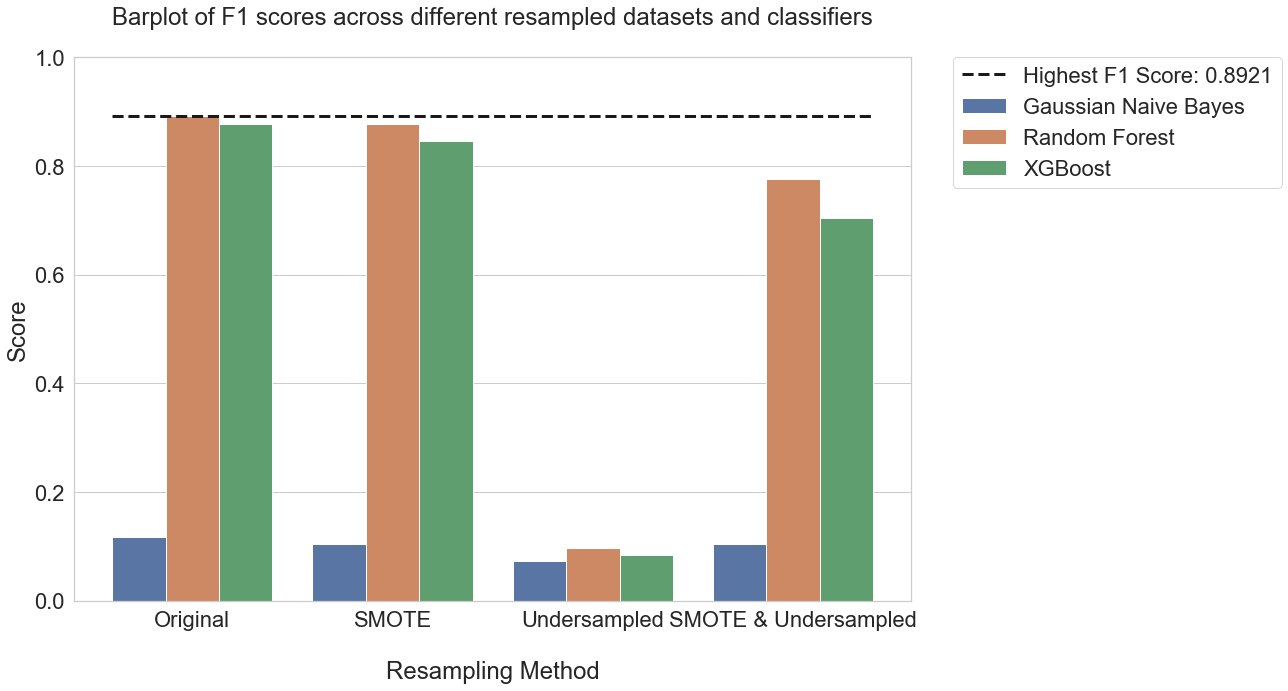

In [247]:
scores_bar_plot(reshape_scores_df(f1_scores_df), 'F1')

In [98]:
max_f1 = combination_for_best_score(f1_scores_df)

The highest score was 0.8921
This was achieved by resampling with Original and using the Random Forest classifier


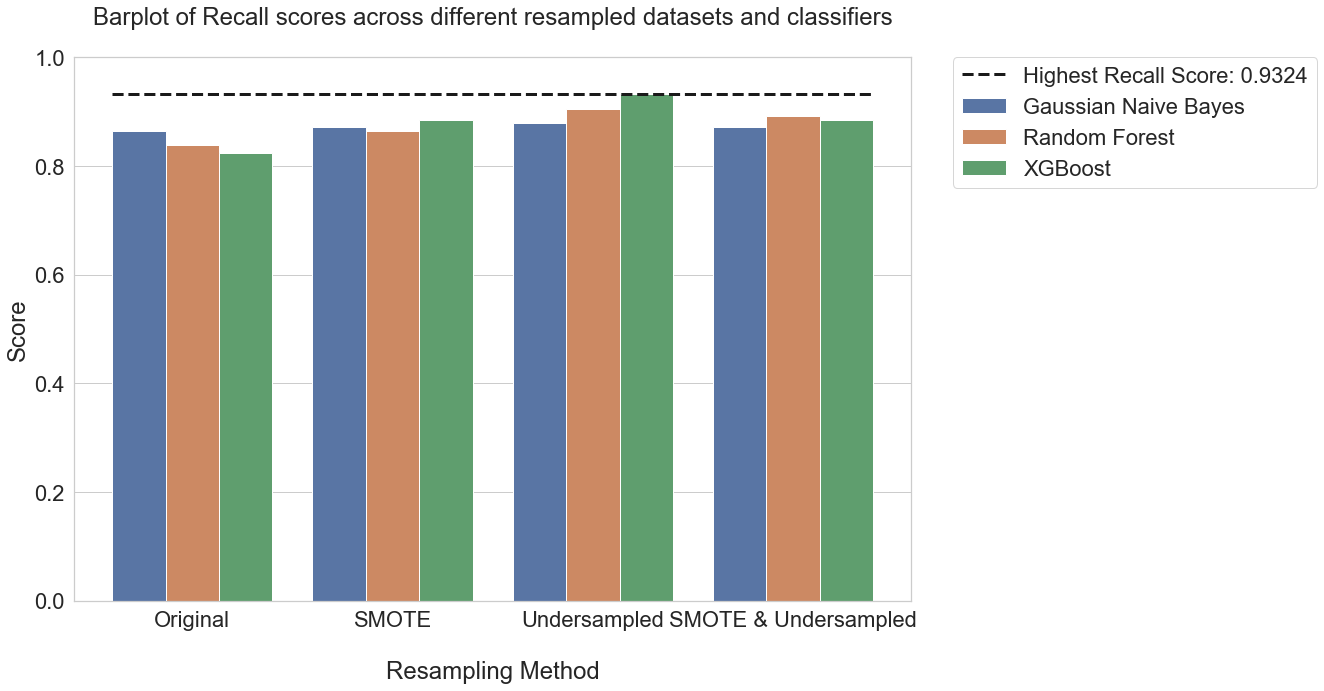

In [248]:
scores_bar_plot(reshape_scores_df(recall_scores_df), 'Recall')

In [99]:
max_recall = combination_for_best_score(recall_scores_df)

The highest score was 0.9324
This was achieved by resampling with Undersampled and using the XGBoost classifier


In [315]:
# Save the predictions from the optimal resampling and classifier
y_pred = y_pred_rf_smote

## Confusion Matrix

Confusion Matrix: 
TN: 85278 FP: 17 FN: 19 TP: 129


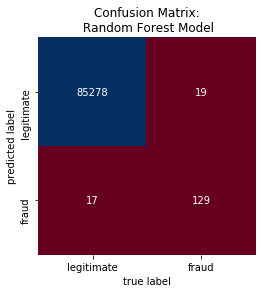

In [184]:
# print confusion matrix    
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt = 'g', cmap='RdBu', cbar=False, xticklabels=['legitimate', 'fraud'], yticklabels=['legitimate', 'fraud'])
plt.title('Confusion Matrix:\n Random Forest Model')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('cm_rf_smote')

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:",'\nTN:', tn, 'FP:', fp, 'FN:', fn, 'TP:', tp)

## ROC CURVE

In [188]:
y_pred_proba = y_pred_proba_rf_smote

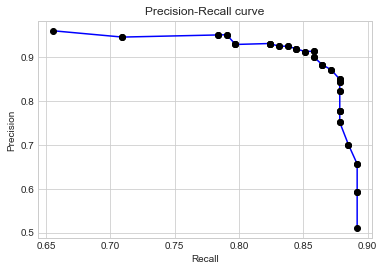

In [189]:
probs = pd.DataFrame(y_pred_proba, columns=['prob_legit', 'prob_fraud'])
probs['actual']=[i for i in y_test]
probs.head()

# # print 
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

names = ['cut_off', 'recall', 'precision']
fraud_metrics = pd.DataFrame()

# for loop to test different cut-off values
for i in frange(.2,.95,.015):
    probs['label'] = np.where(probs['prob_fraud'] >= i, 1, 0)
    tn, fp, fn, tp = confusion_matrix(probs['actual'], probs['label']).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    evals = [i,recall,precision]
    fraud_metrics=fraud_metrics.append(pd.Series(evals), ignore_index=True)

fraud_metrics.columns = names

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plot the data
plt.plot(fraud_metrics.recall, fraud_metrics.precision , '-', color='blue')
plt.plot(fraud_metrics.recall, fraud_metrics.precision , 'o', color='black')
# make some nice labels
plt.title('Precision-Recall curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('pr_curve_rf_smote')

The Receiver operating characteristic (ROC) curve is the typical tool for assessing the performance of machine learning algorithms, but it actually does not measure well for imbalanced data.

The Receiver Operating Characteristic (ROC) curves plot FPR vs. TPR as shown below. Because TPR only depends on positives, ROC curves do not measure the effects of negatives. The area under the ROC curve (AUC) assesses overall classification performance. AUC does not place more emphasis on one class over the other, so it does not reflect the minority class well.

We also looked at Precision-Recall curves to get a sense of how well the model captures true positives. A PR curve plots the Precision and Recall scores across different thresholds for a positive identification. This helps us to see whether a model captures true positives while minimizing false positives and false negatives.

Precision-Recall (PR) curves will be more informative than ROC when dealing with highly skewed datasets. The PR curves plot precision vs. recall (FPR). Because Precision is directly influenced by class imbalance so the Precision-recall curves are better to highlight differences between models for highly imbalanced data sets. When you compare different models with imbalanced settings, the area under the Precision-Recall curve will be more sensitive than the area under the ROC curve.

In [192]:
# Inspecting the amounts of frauds that our model missed
pred_vs_actual = pd.DataFrame({"Amount": X_test['Amount'], "Predicted": y_pred_rf_smote, "Actual": [i for i in y_test]})
pred_vs_actual.loc[(pred_vs_actual['Predicted']==0) & (pred_vs_actual['Actual']==1)]['Amount'].describe()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [270]:
pred_vs_actual = pd.DataFrame()
pred_vs_actual['Amount'] = X_test['Amount']
pred_vs_actual['Predictions'] = y_pred
pred_vs_actual['Test Data'] = y_test
pred_vs_actual['Correct'] = (pred_vs_actual['Predictions']==pred_vs_actual['Test Data']).astype(int)
pred_vs_actual.head()

,Amount,Predictions,Test Data,Correct
31773,104.00,0,0,1
117430,16.48,0,0,1
274383,4.00,0,0,1
216704,18.96,0,0,1
245854,4.99,0,0,1


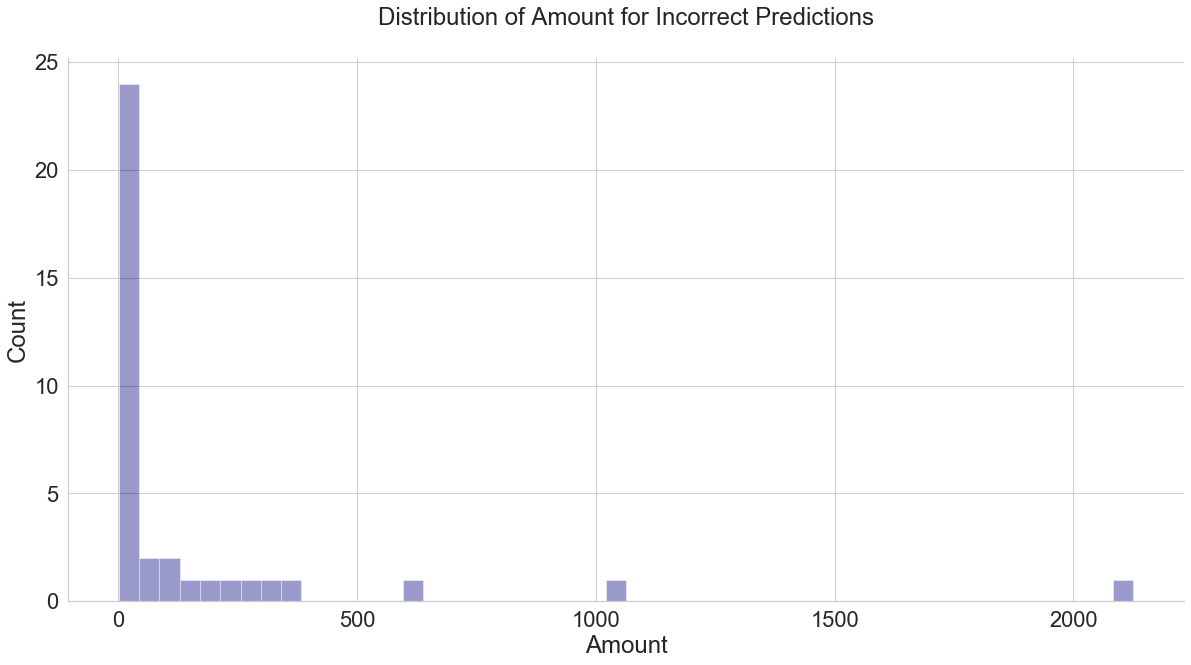

In [314]:
incorrect_predictions = pred_vs_actual['Correct']==0
correct_predictions = pred_vs_actual['Correct']==1

plt.figure(figsize=(20,10))
sns.set(font_scale=2, style='whitegrid', )
ax = sns.distplot(pred_vs_actual[incorrect_predictions]['Amount'], kde=False, color='navy', bins=50)
sns.despine()
plt.ylabel('Count');
ax.set_title('Distribution of Amount for Incorrect Predictions\n',);

## GridSearch

The parameter tuning using GridSearchCV improved our model's performance 
by over 20%, from ~44% to ~66%. The model also shows no signs of 
overfitting, as evidenced by the close training and testing scores. 
Grid Search does not gaurantee that we will always find the globally 
optimal combination of parameter values. Since it only exhaustively 
searches through the parameter values we provide, 
not every possible combination of every possible value for each parameter 
is tested. This means that the model is only as good as the possible 
combinations of the parameters we include in our parameter grid.

 |     Parameter     |         Values         |
|:-----------------:|:----------------------:|
|    n_estimators   |      [10, 30, 100]     |
|     criterion     |   ['gini', 'entropy']  |
|     max_depth     | [None, 2, 6, 10] |
| min_samples_split |       [5, 10]       |
|  min_samples_leaf |   [3, 6]   |

GridSearchCV finds the optimal combination of parameters through an exhaustive combinatoric search. If you search through too many parameters, the model will take forever to run

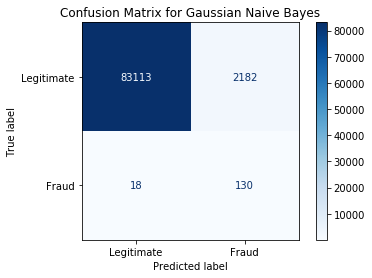

In [21]:
# Plot Confusion Matrix
class_names = ['Legitimate', 'Fraud']

conf_matrx_title = 'Gaussian Naive Bayes'

disp = plot_confusion_matrix(model,
                             X_test,
                             y_test,
                             display_labels=class_names,
                             normalize=None,
                            cmap=plt.cm.Blues)
plt.title('Confusion Matrix for {}'.format(conf_matrx_title));


https://www.scikit-yb.org/en/latest/